In [1]:
from pathlib import Path
from typing import Dict, Tuple
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.notebook import tqdm
import csv
from datetime import datetime
from typing import Iterable, List
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure
from matplotlib.ticker import AutoMinorLocator

# Save result

In [32]:

directory_path = Path("../lightning_logs/theo_cov_013019")

# result_csv_path = Path(f"results_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.csv")
results_dir = Path(f"results/")
results_dir.mkdir(parents=True, exist_ok=True)

total_df = pd.DataFrame()
seeds = sorted([entry for entry in directory_path.iterdir() if entry.is_dir()])

for seed in tqdm(seeds, desc='seed', leave=False):
    seed_name = seed.name
    models = sorted(list(seed.iterdir()))
    for model in models:
        key = (seed_name, model.name)
        version = sorted([entry for entry in model.iterdir() if entry.is_dir()])[-1]
        event = sorted(list(version.glob('event*')))[-1]
        df = EventAccumulator(str(event))
        df.Reload()
        parameter_names = df.Tags()['scalars']
        dataset : Dict[str, any]= {}
        for para_name in parameter_names :
            records = df.Scalars(para_name)
            records_len = len(records)
            if records_len < 2 :
                continue
            step = int(records_len/100)
            if step > 0 :
                records = records[:-1:step] + [records[-1]]
            else :
                pass
            if not 'step' in dataset.keys():
                dataset['step'] = [r.step for r in records]
            dataset[para_name] = [r.value for r in records]
        
        df = pd.DataFrame(dataset)
        df.to_csv(results_dir/Path(f"{seed_name}_{model.name}.csv"), index=False)

seed:   0%|          | 0/1 [00:00<?, ?it/s]

# plot result

In [26]:


def get_model_parameter(
        csv_path : Path, 
        para_names : Iterable[str],
    ) -> Dict[str, float] :
    var_dict : Dict[str, float] = {}
    df = pd.read_csv(csv_path)
    for para_name in para_names:
        y = df[para_name]  # X-axis data
        var_dict[para_name] = y.iloc[-1]
    return var_dict

def stack_model_parameter(
        csv_paths: Iterable[Path],
        para_names: Iterable[str],
    ) -> Dict[str, List[float]] :
    list_dict : Dict[str, List[float]] = {}
    for csv_path in csv_paths:
        para_dict = get_model_parameter(
            csv_path=csv_path,
            para_names=para_names
        )
        for name, value in para_dict.items():
            value_list = list_dict.get(name, [])
            value_list.append(value)
            list_dict[name] = value_list
    return list_dict

def collect_models(
        csv_paths_list: Iterable[Iterable[Path]],
        model_names : Iterable[str] = ['total','base', '1_2_3', '1_2', '1_3', '2_3', '1', '2', '3'],
        para_names: Iterable[str] = ['train_loss', 'v','k_a', 'k_e', 'omega_v', 'omega_k_a', 'omega_k_e', 'error',],
) -> Dict[Tuple[str,str],List[float]] :
    parameter_name = str
    model_name = str
    para_model_dict : Dict[parameter_name,Dict[model_name,List(float)]] = {}
    for model_name, csv_paths in zip(model_names, csv_paths_list):
        para_list_dict = stack_model_parameter(
            csv_paths=csv_paths,
            para_names=para_names)
        for para_name, para_list in para_list_dict.items():
            model_dict = para_model_dict.get(para_name, {})
            model_dict[model_name] = para_list
            para_model_dict[para_name] = model_dict
    return para_model_dict
    
from matplotlib import rcParams
results_path = Path('results')
total_path_list = results_path.glob('*.csv')
base_path_list = results_path.glob('*base_model.csv')
cov_1_2_3_path_list = results_path.glob('*cov_1_2_3_model.csv')
cov_1_2_path_list = results_path.glob('*cov_1_2_model.csv')
cov_1_3_path_list = results_path.glob('*cov_1_3_model.csv')
cov_2_3_path_list = results_path.glob('*cov_2_3_model.csv')
cov_1_list = results_path.glob('*cov_1_model.csv')
cov_2_list = results_path.glob('*cov_2_model.csv')
cov_3_list = results_path.glob('*cov_3_model.csv')
model_path_list = [total_path_list, base_path_list, cov_1_2_3_path_list, cov_1_2_path_list, cov_1_3_path_list, cov_2_3_path_list, cov_1_list, cov_2_list, cov_3_list]
para_names =  ['train_loss', 'v','k_a', 'k_e', 'omega_v', 'omega_k_a', 'omega_k_e', 'error',]
model_names = ['total','base', '1_2_3', '1_2', '1_3', '2_3', '1', '2', '3']

rcParams['font.size']=10

dataset = collect_models(
    csv_paths_list=model_path_list,
    model_names=model_names,
    para_names=para_names)



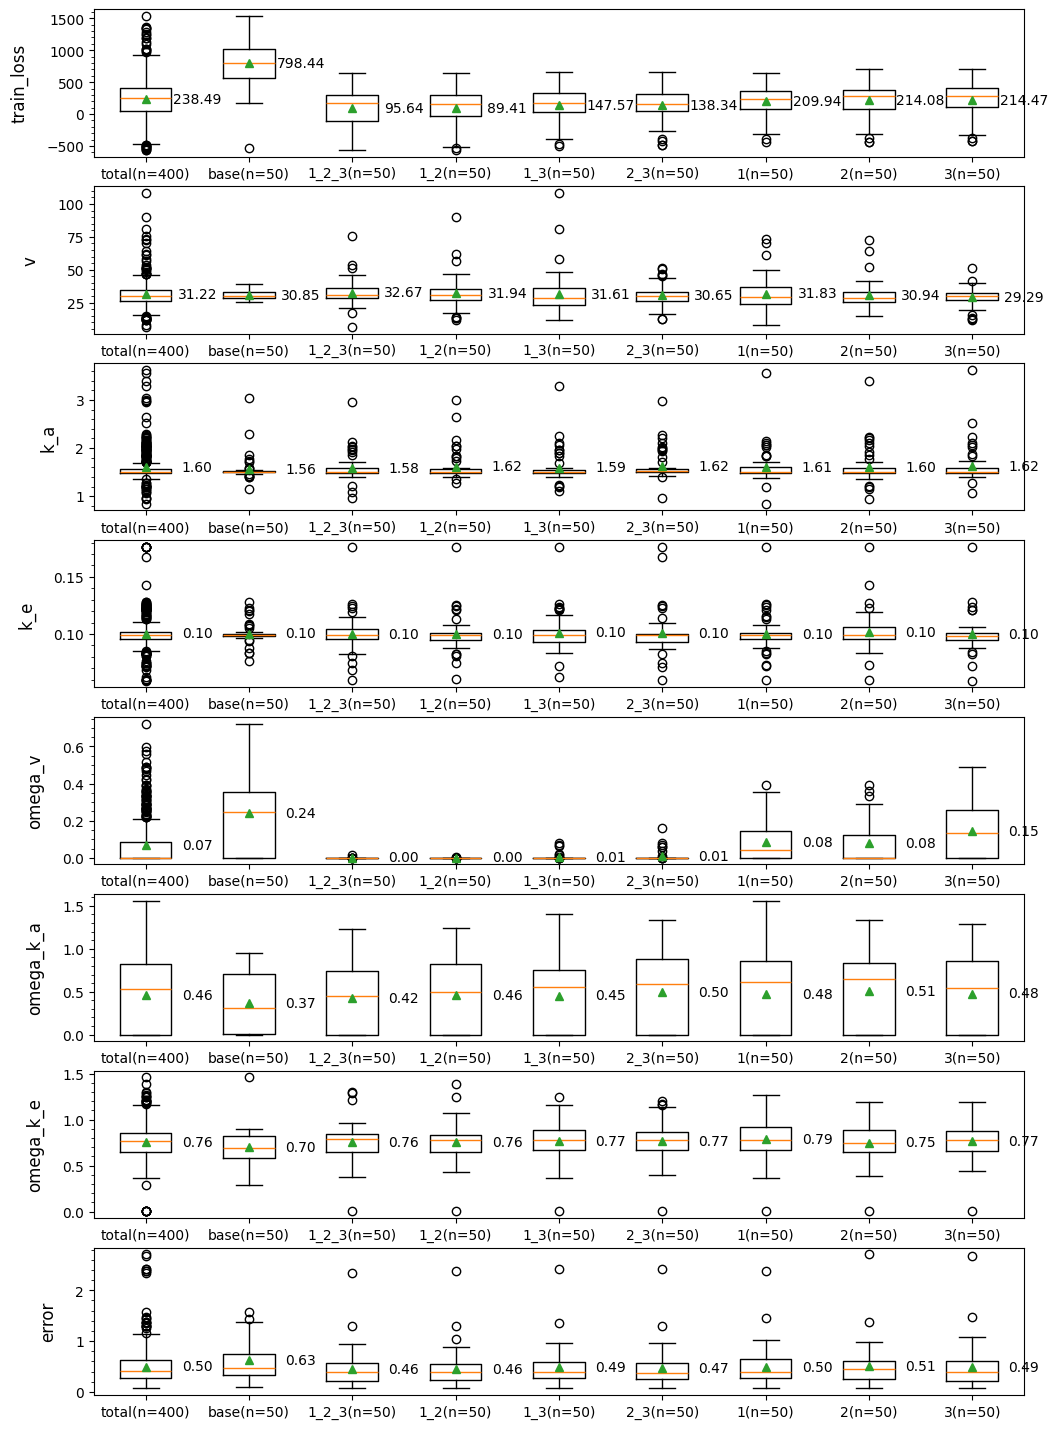

In [27]:
fig, axs  = plt.subplots(8, 1, figsize=(12,18))
axs = axs.flatten()
for i, para_name in enumerate(para_names) :
    values = []
    for model_i, model_name in enumerate(model_names) :
        value = dataset[para_name][model_name]
        values.append(value)
        mean = np.mean(np.array(value))
        axs[i].text(model_i+1.5, mean, f'{mean:.2f}', va='center', ha='center')
    axs[i].boxplot(values, showmeans=True)
    axs[i].set_xticklabels([f'{name}(n={len(value)})' for name, value in zip(model_names, values)])
for ax, row in zip(axs, para_names):
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


# VPC

In [3]:
directory_path = Path("../lightning_logs/theo_cov_013019")

# result_csv_path = Path(f"results_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.csv")
results_dir = Path(f"results/")
results_dir.mkdir(parents=True, exist_ok=True)

total_df = pd.DataFrame()

model_name = str
pred_dict: Dict[model_name, np.array]= {}
seeds = sorted([entry for entry in directory_path.iterdir() if entry.is_dir()])
for seed in tqdm(seeds, desc='seed', leave=False):
    seed_name = seed.name
    models = sorted(list(seed.iterdir()))
    for model in models:
        pred_npy_path = model/Path('pred.npy')
        pred = pred_dict.get(model.name, None)
        if pred is None :
            pred_dict[model.name] = np.load(pred_npy_path)
        else :
            pred_dict[model.name] = np.concatenate([pred, np.load(pred_npy_path)])


seed:   0%|          | 0/50 [00:00<?, ?it/s]

base_model
cov_1_2_3_model
cov_1_2_model
cov_1_3_model
cov_1_model
cov_2_3_model
cov_2_model
cov_3_model


/tmp/ipykernel_743645/2763971949.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(np.repeat(time, preds.shape[0]).flatten(), np.exp(preds).flatten(), vmin=0, vmax=10)


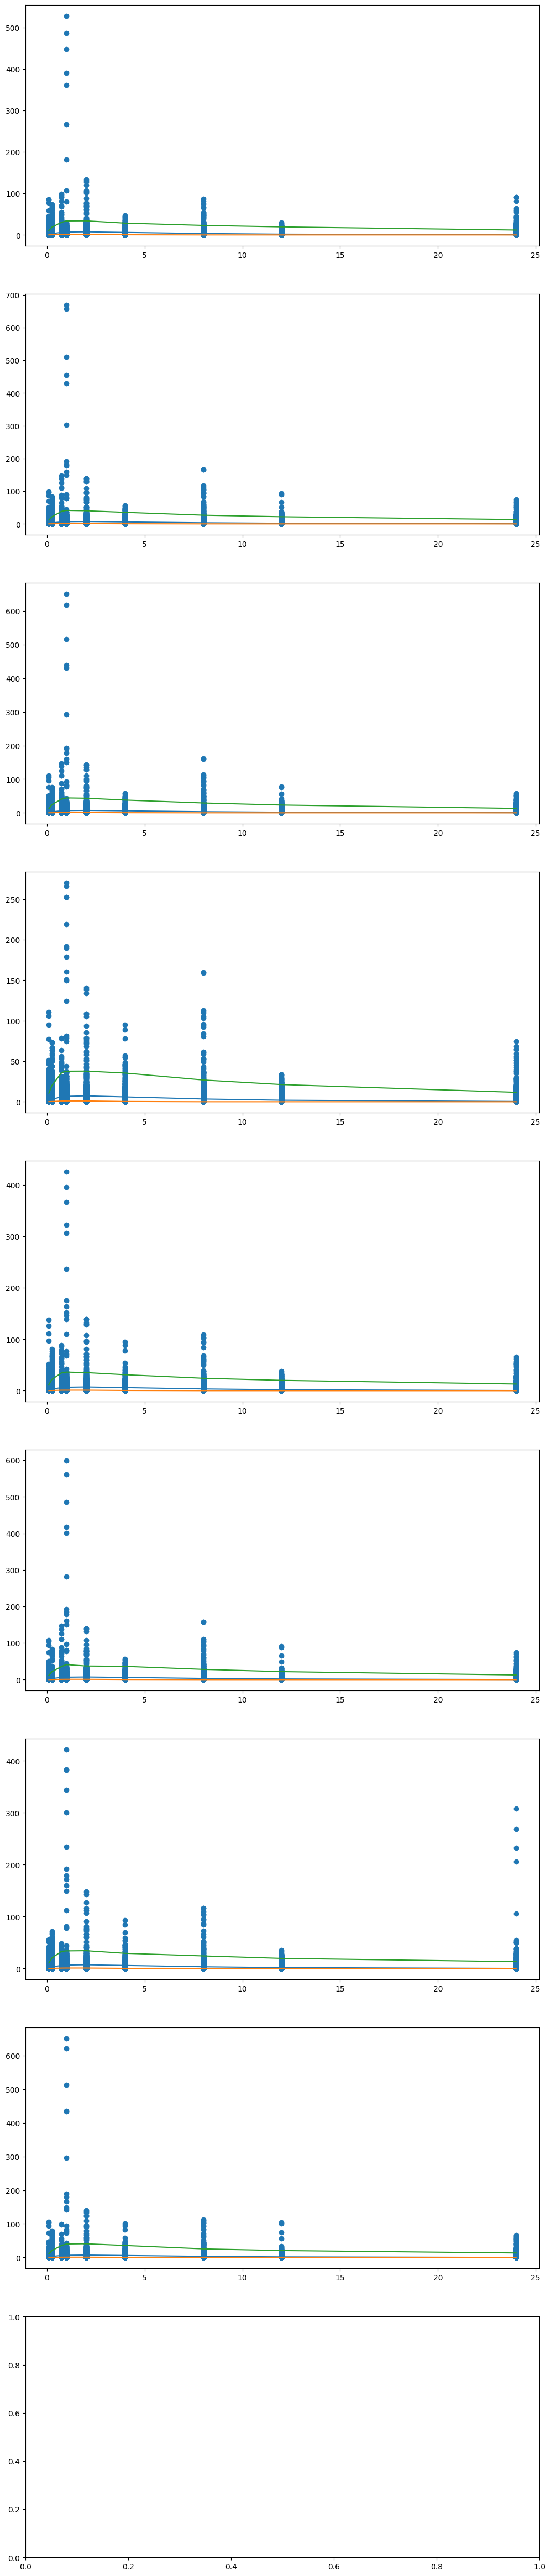

In [24]:
fig, axs = plt.subplots(9,1, figsize=(12,60))
time = np.array([0.1,0.25,0.75,1.,2.,4.,8.,12.,24.])

for ax, (model_name, preds) in zip(axs, pred_dict.items()):
    print(model_name)
    # ax.set_ylim(0,40)
    preds = np.squeeze(preds, -1)
    means = preds.mean(0)
    percentile_5, percentile_95 = np.percentile(preds, [1,99], axis=0)
    # for pred in preds :
    
    ax.scatter(np.repeat(time, preds.shape[0]).flatten(), np.exp(preds).flatten(), vmin=0, vmax=10)

    for value in [means, percentile_5, percentile_95]:
        ax.plot(time, np.exp(value))